<a href="https://cbitek.com/"><img src="https://cbitek.com/wp-content/uploads/2019/08/Genome.jpg" width="200" align="center"></a>

<h1 align=center><font size="5"> 
Some Methods of Genome Clustering</font></h1>

In [128]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import pylab
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from scipy import ndimage 
from sklearn.cluster import KMeans 
from scipy.cluster.hierarchy import fcluster

# k-Means Clustering

<h3>Import Dataset</h3>

In [129]:
df_diauxic_shift = pd.read_csv('D:/Data Science/Coursera/Bioinformatics/Data/230genes_log_expression.csv')
df_diauxic_shift.head()

,Name,R1.Ratio,R2.Ratio,R3.Ratio,R4.Ratio,R5.Ratio,R6.Ratio,R7.Ratio
0,YDR025W RPS18A,0.136062,-0.111031,-0.189034,-0.782409,-0.757023,-0.855990,-2.304511
1,YDR031w,-0.286881,-0.084064,0.184425,0.136062,0.535332,2.321928,1.251539
2,YDR060w,-0.042644,-0.097611,-0.014355,-0.799087,-0.839960,-2.247928,-2.386811
3,YDR064W YS15,-0.056584,-0.124328,-0.070389,-0.545968,-0.555816,-2.104337,-2.367371
4,YDR070c,0.014500,0.074001,0.058894,0.014500,0.251539,2.395929,1.689660


In [130]:
df_diauxic_shift.columns.values

array(['Name', 'R1.Ratio', 'R2.Ratio', 'R3.Ratio', 'R4.Ratio', 'R5.Ratio',
       'R6.Ratio', 'R7.Ratio'], dtype=object)

In [131]:
df_diauxic_shift_new = df_diauxic_shift.set_index('Name')
df_diauxic_shift_new.head()

,R1.Ratio,R2.Ratio,R3.Ratio,R4.Ratio,R5.Ratio,R6.Ratio,R7.Ratio
Name,,,,,,,
YDR025W RPS18A,0.136062,-0.111031,-0.189034,-0.782409,-0.757023,-0.855990,-2.304511
YDR031w,-0.286881,-0.084064,0.184425,0.136062,0.535332,2.321928,1.251539
YDR060w,-0.042644,-0.097611,-0.014355,-0.799087,-0.839960,-2.247928,-2.386811
YDR064W YS15,-0.056584,-0.124328,-0.070389,-0.545968,-0.555816,-2.104337,-2.367371
YDR070c,0.014500,0.074001,0.058894,0.014500,0.251539,2.395929,1.689660


<h3> Normalizing Data</h3>

In [132]:
#for i in range(df_diauxic_shift_new.shape[1]):
    #df_diauxic_shift_new[df_diauxic_shift_new.columns.values[i]] = (df_diauxic_shift_new.iloc[:, i] - np.min(df_diauxic_shift_new.iloc[:, i]))/(np.max(df_diauxic_shift_new.iloc[:, i]) - np.min(df_diauxic_shift_new.iloc[:, i])) 
#df_diauxic_shift_new.head()

<h3>Initializing Centers</h3>

In [133]:
def Initialize_Centers(df, K):
    centers = [df.iloc[0, :].values.tolist()]
    new_df = df[1::]
   
    while len(centers) < K:
        n = new_df.shape[0]
        dist = []
        
        for i in range(n):
            dist_i = []
            for j in range(len(centers)):
                dist_i.append(np.square(np.linalg.norm(new_df.iloc[i, :] - centers[j])))
                
            min_dist = min(dist_i)  
            dist.append(min_dist)
          
        new_index = np.argmax(dist)
            
        new_center = new_df.iloc[new_index, :].values.tolist()
        new_df.drop(new_df.index[new_index], axis = 0, inplace = True)
        centers.append(new_center) 
        
    return(centers)

<h3>k-Means-Clustering ++ Initializer</h3>

In [134]:
def k_Means_Clustering(df, K, iterations):
    
    N = df.shape[0]
    z = np.zeros((N, 1));
    new_centers = Initialize_Centers(df, K)
    count_it = 0
    hist_centers = [new_centers]
    X = np.zeros((1, K)).tolist()[0]
    
    
    for t in range(iterations):
        distor = 0
        count_it += 1
        coordinates = []
        distances = np.zeros((N, K));
        X_k = []
        new_c = []
        length = []
        ind = np.zeros((1, K)).tolist()[0]
        
        # Assign a cluster index for every data points 
        for i in range(N):
            for k in range(K):
                distances[i, k] = np.linalg.norm(df.iloc[i,:] - new_centers[k])
            z[i] = min(distances[i, :])
            
        # Update new centers for all clusters
        for k in range(K):
            index = []
            for i in range(N):
                if distances[i, k] == z[i]:
                    index.append(i)
            ind[k] = index
            X[k] = df.iloc[index, :]
            X_k.append(X[k])
            
        for x in X_k:
            new_c.append(np.mean(x).values.tolist())
            length.append(len(x))
            distor += np.square(np.linalg.norm((x-np.mean(x)).values))
            
        new_centers = new_c
        hist_centers.append(new_centers)
            
        if np.linalg.norm(np.array(hist_centers[-1]) - np.array(hist_centers[-2])) < 1e-4:
            break
     
    df_labels = pd.DataFrame(df.index.tolist(), columns = ['Name'])
    df_labels['Labels'] = [0 for p in range(N)]
    
    for m in range(len(ind)):
        df_labels.loc[df_labels.index[ind[m]], 'Labels'] = [m for i in range(len(ind[m]))]
    df_labels.set_index('Name', inplace = True)
    
    return(new_centers, X_k, length, count_it, distor, df_labels)

In [135]:
new_centers, X_clustering, length, count_it, distor, df_labels = k_Means_Clustering(df_diauxic_shift_new, 6, 300)
distor

182.32340602110833

In [136]:
df_labels.head(10)

,Labels
Name,
YDR025W RPS18A,0
YDR031w,3
YDR060w,5
YDR064W YS15,5
YDR070c,4
YDR144C MKC7,5
YDR171W HSP42,1
YDR178W SDH4,1
YDR258C HSP78,3


In [137]:
df_labels.loc['YDL204w', :]

Labels    4
Name: YDL204w, dtype: int64

In [138]:
def Draw_Clusters(df, length, count_it):
    print('The algorithm converges after '+ str(count_it) + ' iterations')
    count = 0
    for cluster in df:
        cluster = cluster.transpose()
        cluster.reset_index(inplace = True)
        cluster.plot(kind='line', x = 'index', legend = False, figsize=(10, 6), colormap = 'rainbow')
        count +=1
        plt.title('Cluster '+ str(count) + ' with ' + str(length[count-1]) + ' Gennes')
        plt.xlabel('Time')
        plt.ylabel('Values')
        plt.show()

The algorithm converges after 8 iterations


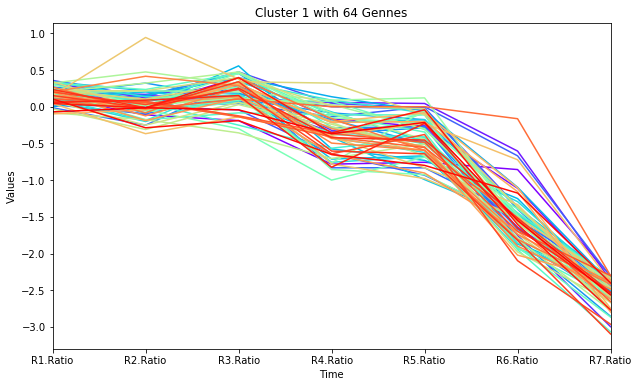

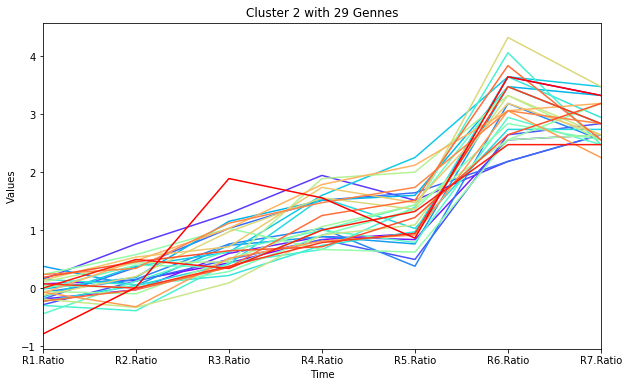

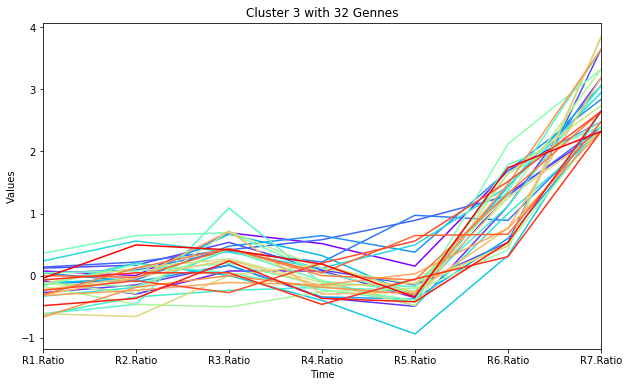

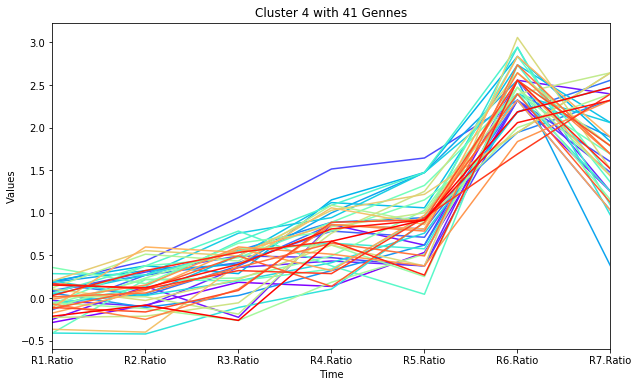

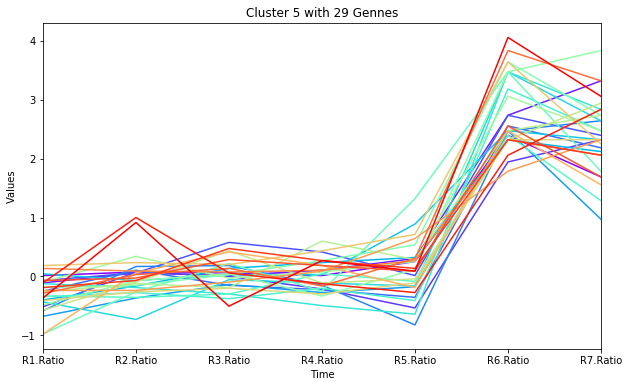

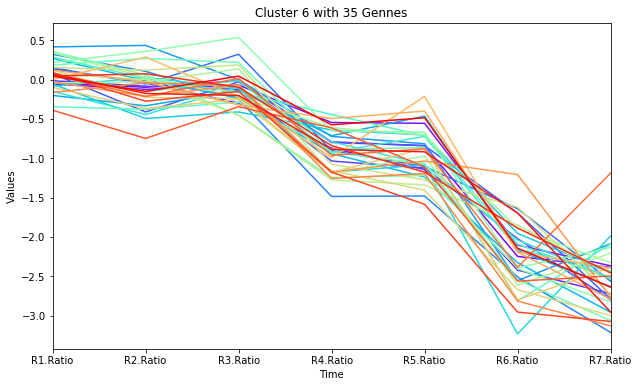

In [139]:
Draw_Clusters(X_clustering, length, count_it)

<h3>Soft k-Means Clustering</h3>

In [140]:
def Get_Soft_k_Means(df, K, iterations, beta):
    N = df.shape[0]
    z = np.zeros((N, 1));
    new_centers = Initialize_Centers(df, K)
    hidden_matrix = np.zeros((K, N))         
    count_it = 0
    length = []
    hist_centers = [new_centers]
    X = np.zeros((1, K)).tolist()[0]
    square_of_distances = 0
    labels = [0 for q in range(N)]
    
    for t in range(iterations):
        count_it += 1
        coordinates = []
        distances = np.zeros((N, K));
        X_k = []
        ind = np.zeros((1, K)).tolist()[0]
        new_c = []
        
        # Center to Soft Clusters
        for j in range(N):
            for i in range(K):
                hidden_matrix[i, j] = np.exp(-beta*np.linalg.norm(np.array(df.iloc[j, :].tolist())-np.array(new_centers[i])))
            hidden_matrix[:, j] = hidden_matrix[:, j]/sum(hidden_matrix[:, j])  
        
        # Soft Clusters to Centers
        new_c = (np.dot(hidden_matrix, np.array(df.iloc[:, :]))/np.sum(hidden_matrix, axis = 1, keepdims = True)).tolist()   
        new_centers = new_c
        # Final Clusters
        for j in range(N):
            labels[j] = np.argmax(hidden_matrix[:, j])   
            
        hist_centers.append(new_centers)
        
        if (np.linalg.norm(np.array(hist_centers[-1]) - np.array(hist_centers[-2])))**2 < 1e-4:
            break
    
    df_labels = df[::]
    df_labels['Labels'] = labels
    
    for k in range(K):
        X[k] = df_labels[df_labels['Labels'] == k]
        X[k].drop(columns = ['Labels'], inplace = True)
        length.append(X[k].shape[0])
        
    for x in X:
        square_of_distances += np.square(np.linalg.norm((x-np.mean(x)).values))

    return(new_centers, X, length, count_it, square_of_distances, df_labels)
    

In [141]:
new_centers_2, X_clustering_2, length_2, count_it_2, distor_2, df_labels_2 = Get_Soft_k_Means(df_diauxic_shift_new, 6, 300, 10)
distor_2

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


179.4611023672627

The algorithm converges after 18 iterations


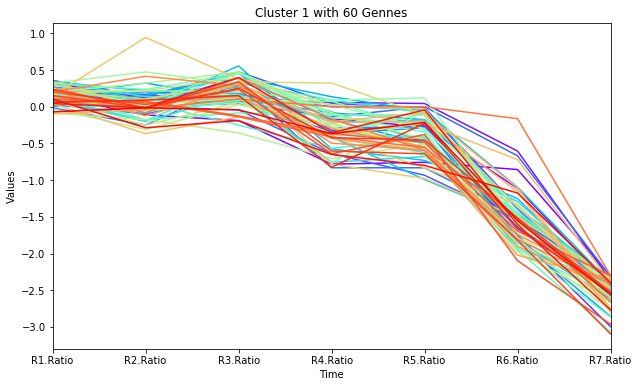

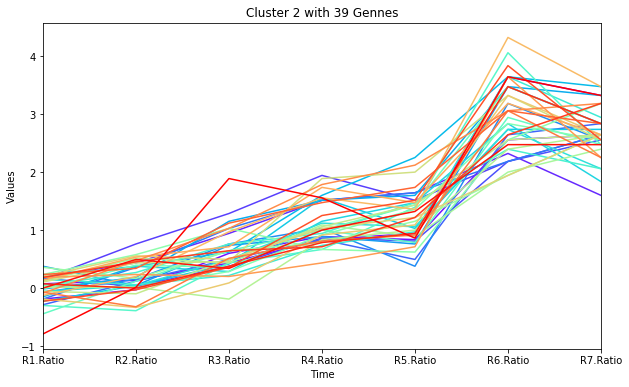

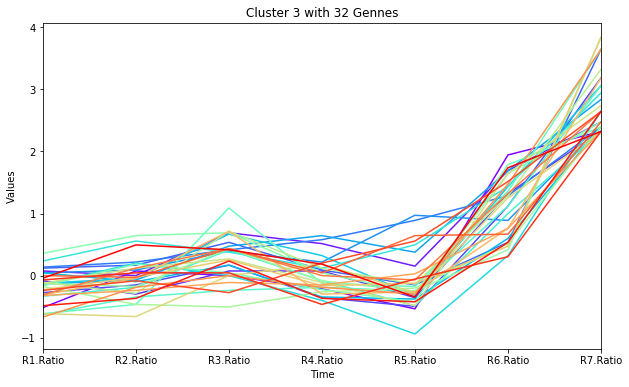

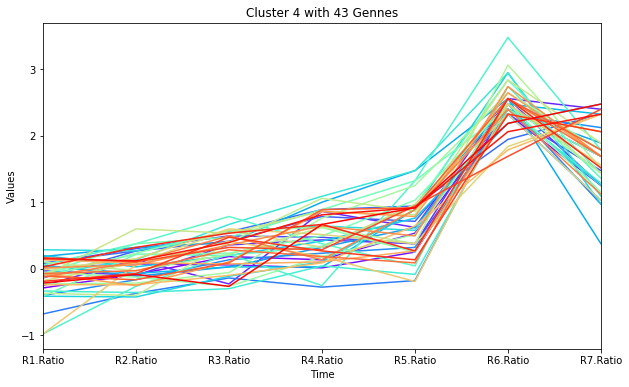

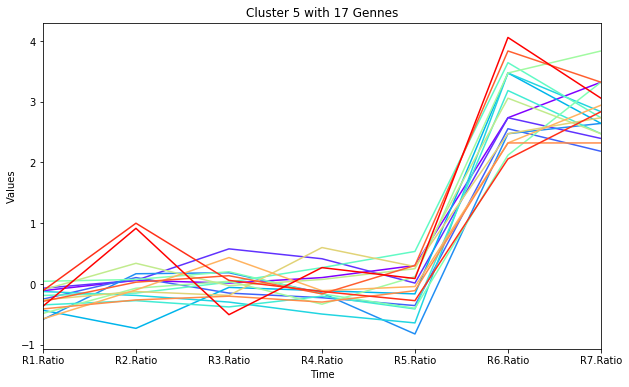

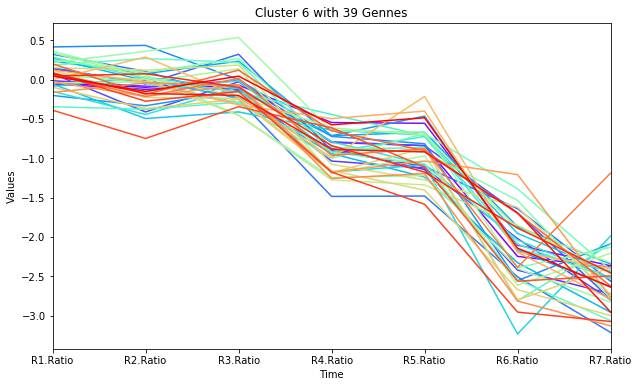

In [142]:
Draw_Clusters(X_clustering_2, length_2, count_it_2)

# Using Library

In [143]:
def Choose_K(df):
    distortions = []
    for i in range(1, 21):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=20, max_iter=300,
            tol=1e-04, random_state=0
        )
        km.fit(df)
        distortions.append(km.inertia_)

    # plot
    plt.plot(range(1, 21), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

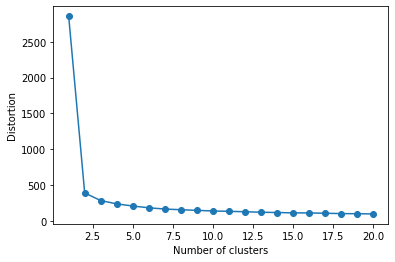

In [144]:
Choose_K(df_diauxic_shift_new)

In [145]:
def Use_k_Means_Lib(df, K, iterations):
    
    k_means = KMeans(init = "k-means++", n_clusters = K, tol=1e-04, n_init = iterations)
    k_means.fit(df)
    k_means_labels = k_means.labels_
    k_means_cluster_centers = k_means.cluster_centers_
    length_lib = []
    X_lib = np.zeros((1, K)).tolist()[0]

    df_labels_lib = df_diauxic_shift_new[::]
    df_labels_lib['Labels'] = k_means_labels.tolist()
  
    for k in range(K):
        X_lib[k] = df_labels_lib[df_labels_lib['Labels'] == k]
        X_lib[k].drop(columns = ['Labels'], inplace = True)
        length_lib.append(X_lib[k].shape[0])
    print('Distortion', k_means.inertia_)
    return(Draw_Clusters(X_lib, length_lib, iterations))

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Distortion 179.4101335495111
The algorithm converges after 100 iterations


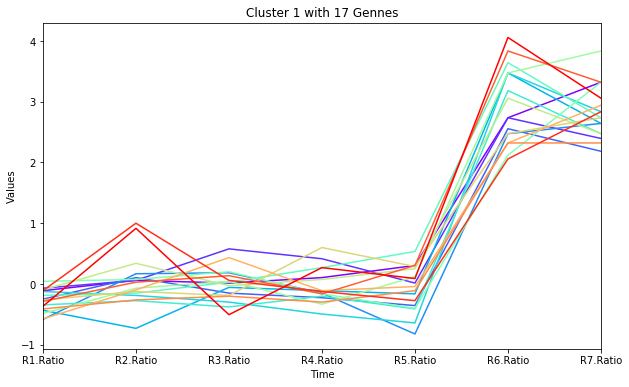

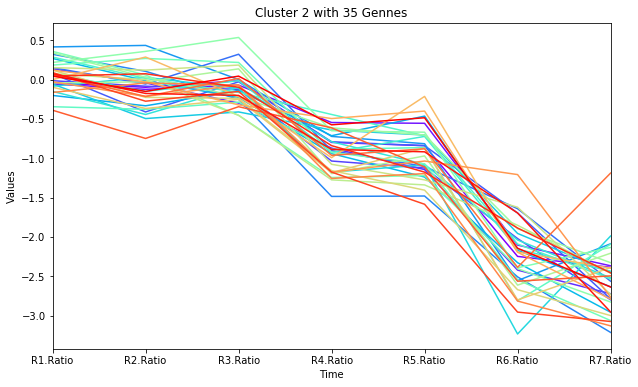

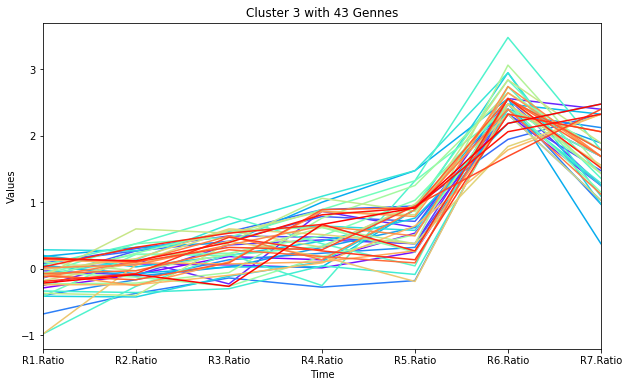

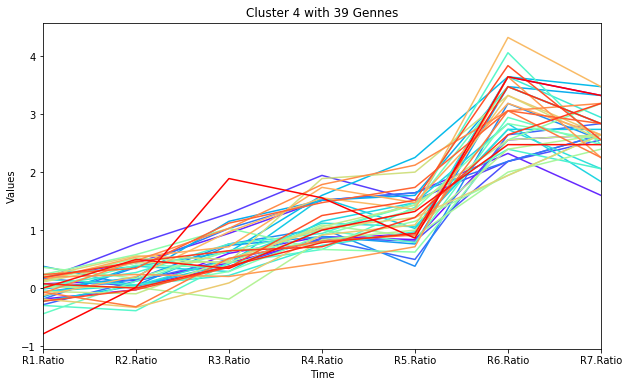

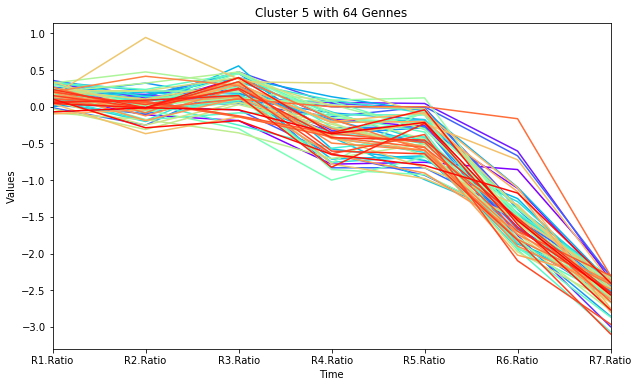

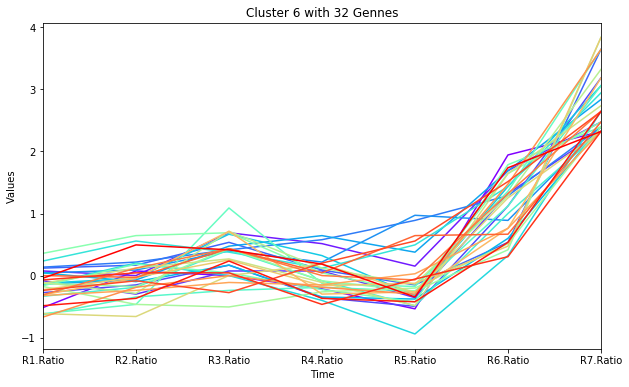

In [146]:
Use_k_Means_Lib(df_diauxic_shift_new, 6, 100)

# Hierarchical Clustering

In [147]:
df  = pd.read_csv('D:/Data Science/Coursera/Bioinformatics/Data/230genes_log_expression.csv')
df.head()

,Name,R1.Ratio,R2.Ratio,R3.Ratio,R4.Ratio,R5.Ratio,R6.Ratio,R7.Ratio
0,YDR025W RPS18A,0.136062,-0.111031,-0.189034,-0.782409,-0.757023,-0.855990,-2.304511
1,YDR031w,-0.286881,-0.084064,0.184425,0.136062,0.535332,2.321928,1.251539
2,YDR060w,-0.042644,-0.097611,-0.014355,-0.799087,-0.839960,-2.247928,-2.386811
3,YDR064W YS15,-0.056584,-0.124328,-0.070389,-0.545968,-0.555816,-2.104337,-2.367371
4,YDR070c,0.014500,0.074001,0.058894,0.014500,0.251539,2.395929,1.689660


In [148]:
df_new = df.set_index('Name')
df_new = df_new.transpose()
df_new

Name,YDR025W RPS18A,YDR031w,YDR060w,YDR064W YS15,YDR070c,YDR144C MKC7,YDR171W HSP42,YDR178W SDH4,YDR258C HSP78,YBL015W ACH1,...,YDL215C GDH2,YDR258C HSP78,YCR010C,YCR021c HSP30,YDL083C,YDL085w,YDL136w,YDL199c,YDL204w,YDL208W NHP2
R1.Ratio,0.136062,-0.286881,-0.042644,-0.056584,0.014500,0.136062,0.074001,-0.189034,-0.250962,-0.111031,...,-0.070389,-0.214125,-0.485427,-0.790772,0.104697,-0.111031,-0.070389,-0.042644,-0.367371,0.043943
R2.Ratio,-0.111031,-0.084064,-0.097611,-0.124328,0.074001,-0.042644,0.136062,-0.028569,0.136062,0.058894,...,0.043943,-0.084064,-0.367371,0.014500,-0.286881,1.000000,-0.014355,0.494109,0.915936,-0.150560
R3.Ratio,-0.189034,0.184425,-0.014355,-0.070389,0.058894,-0.298658,0.434403,0.599462,-0.226509,0.014500,...,0.043943,-0.263034,0.234465,1.888969,-0.189034,0.058894,-0.042644,0.415037,-0.505891,0.043943
R4.Ratio,-0.782409,0.136062,-0.799087,-0.545968,0.014500,-0.871844,0.836501,0.888969,0.862496,0.104697,...,-0.464668,0.666576,-0.367371,1.556393,-0.650765,-0.124328,-0.367371,0.184425,0.268817,-0.575312
R5.Ratio,-0.757023,0.535332,-0.839960,-0.555816,0.251539,-1.144046,0.943416,0.836501,0.621488,0.304006,...,-0.056584,0.915936,-0.422233,0.862496,-0.799087,-0.275007,-0.214125,-0.344828,0.089267,-0.485427
R6.Ratio,-0.855990,2.321928,-2.247928,-2.104337,2.395929,-2.422233,3.643856,2.556393,2.556393,2.736966,...,0.304006,2.184425,0.535332,3.643856,-1.176323,2.058894,-1.550901,1.736966,4.058894,-2.144046
R7.Ratio,-2.304511,1.251539,-2.386811,-2.367371,1.689660,-2.722466,3.321928,2.643856,2.395929,3.321928,...,2.321928,2.473931,2.643856,3.321928,-2.400538,2.836501,-2.563158,2.321928,3.058894,-2.636915


Normalization

In [149]:
#for i in range(df_new.shape[1]):
    #df_new[df_new.columns.values[i]] = (df_new.iloc[:, i] - np.mean(df_new.iloc[:, i]))/np.std(df_new.iloc[:, i])
#df_new

<h3>Pearsonr Distance Matrix</h3> 

Getting Pearsonr corelation 

In [150]:
def Get_Pearsonr_Correlation(x, y):
    numer = 0
    denom_1 = 0
    denom_2 = 0
    
    for i in range(len(x)):
        
        numer = numer + (x[i] - np.mean(x))*(y[i] - np.mean(y))
        denom_1 = denom_1 + (x[i] - np.mean(x))**2
        denom_2 = denom_2 + (y[i] - np.mean(y))**2
        
    denom = np.sqrt(denom_1*denom_2)
    cor = numer/denom
    return(cor)
        

Getting distance matrix by pearsonr correlation

In [151]:
def Get_Pearsonr_Distance_Matrix(df):
    N = len(df.columns.values)
    matrix = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            if i != j:
                # Using library Scipy.stats.pearsonr
                #m = stats.pearsonr(df.iloc[:, i], df.iloc[:,  j])[0]
                # Using definition
                m = Get_Pearsonr_Correlation(df.iloc[:, i], df.iloc[:,  j])
                m = 1 - m
                matrix[i][j] = m
            else:
                matrix[i][j] = 0
    return(matrix)   
    

<h3> Euclidean Distance Matrix</h3>

Getting Euclidean corelation 

In [152]:
def Get_Euclidean_Distance(x, y):
    dist = 0
    for i in range(len(x)):
        dist = dist + (x[i] - y[i])**2
    dist = np.sqrt(dist)
    dist = round(dist, 1)
    return(dist)

Getting distance matrix by Euclidean correlation

In [153]:
def Get_Euclidean_Distance_Matrix(df):
    N = len(df.columns.values)
    matrix = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            if i != j:
                m = Get_Euclidean_Distance(df.iloc[:, i], df.iloc[:,  j])
                matrix[i][j] = m
            else:
                matrix[i][j] = 0
    return(matrix)   

In [154]:
dist_matrix = Get_Euclidean_Distance_Matrix(df_new)
dist_matrix

array([[0. , 5.1, 1.4, ..., 5.5, 7.5, 1.4],
       [5.1, 0. , 6.1, ..., 1.6, 2.8, 6.1],
       [1.4, 6.1, 0. , ..., 6.3, 8.5, 0.5],
       ...,
       [5.5, 1.6, 6.3, ..., 0. , 2.7, 6.4],
       [7.5, 2.8, 8.5, ..., 2.7, 0. , 8.6],
       [1.4, 6.1, 0.5, ..., 6.4, 8.6, 0. ]])

In [155]:
dfm = pd.DataFrame(dist_matrix, columns = df_new.columns.values)
dfm['index'] = df_new.columns.values
dfm.set_index('index', inplace = True)
dfm

,YDR025W RPS18A,YDR031w,YDR060w,YDR064W YS15,YDR070c,YDR144C MKC7,YDR171W HSP42,YDR178W SDH4,YDR258C HSP78,YBL015W ACH1,...,YDL215C GDH2,YDR258C HSP78,YCR010C,YCR021c HSP30,YDL083C,YDL085w,YDL136w,YDL199c,YDL204w,YDL208W NHP2
index,,,,,,,,,,,,,,,,,,,,,
YDR025W RPS18A,0.0,5.1,1.4,1.3,5.3,1.7,7.6,6.5,6.2,6.8,...,4.8,6.1,5.2,8.1,0.4,6.1,1.0,5.5,7.5,1.4
YDR031w,5.1,0.0,6.1,5.9,0.7,6.5,2.6,1.7,1.5,2.1,...,2.5,1.5,2.5,3.4,5.3,2.1,5.5,1.6,2.8,6.1
YDR060w,1.4,6.1,0.0,0.4,6.3,0.6,8.6,7.4,7.1,7.7,...,5.4,7.0,5.8,8.9,1.1,6.9,1.1,6.3,8.5,0.5
YDR064W YS15,1.3,5.9,0.4,0.0,6.1,0.9,8.4,7.2,6.9,7.6,...,5.3,6.7,5.7,8.7,1.0,6.8,0.7,6.2,8.4,0.3
YDR070c,5.3,0.7,6.3,6.1,0.0,6.8,2.4,1.5,1.2,1.7,...,2.3,1.3,2.3,3.3,5.6,1.6,5.8,1.2,2.4,6.3
YDR144C MKC7,1.7,6.5,0.6,0.9,6.8,0.0,9.0,7.8,7.6,8.1,...,5.9,7.4,6.3,9.4,1.4,7.3,1.4,6.7,8.9,0.9
YDR171W HSP42,7.6,2.6,8.6,8.4,2.4,9.0,0.0,1.3,1.6,1.4,...,3.9,1.9,3.7,1.8,7.9,2.5,8.0,2.6,1.7,8.6
YDR178W SDH4,6.5,1.7,7.4,7.2,1.5,7.8,1.3,0.0,0.9,1.3,...,2.9,1.0,2.8,2.0,6.7,2.0,6.9,1.7,2.3,7.4
YDR258C HSP78,6.2,1.5,7.1,6.9,1.2,7.6,1.6,0.9,0.0,1.3,...,2.7,0.6,2.7,2.7,6.4,1.8,6.6,1.6,2.0,7.1


<h3>Getting Hierarchical Clustering</h3>

In [156]:
def Get_Hierarchical_Clustering(df, dist_type):
    D = df[::]
    Clusters = D.columns.values.tolist()
    
    while len(Clusters) > 1:
        # Distance between vectors
        d = [] 
        # Names of gens coresponds to their distance
        pair = []
        # The set of distance from a gen to another gens
        z = []
        
        # Finding the min distance amongs gen vectors
        for k in (range(len(Clusters))):
            for l in (range(len(Clusters))):
                if k != l and k<l:
                    d.append(D.iloc[k, l])
                    pair.append([Clusters[k], Clusters[l]])   
        # Showing names of gens having the distance that is minimum            
        index = np.argmin(d)
        nodes = pair[index]
        
        # Deleting the old gens
        u = D[nodes[0]].values.tolist()
        v = D[nodes[1]].values.tolist()
        a = (D.columns.values == nodes[0]).tolist().index(True)
        b = (D.columns.values == nodes[1]).tolist().index(True)
        u = np.delete(u, (a, b))
        v = np.delete(v, (a, b))
        Clusters.remove(nodes[0])
        Clusters.remove(nodes[1])
        
        # With the average distance method
        if dist_type == 'average':
            for i in range(len(Clusters)):
                t = u[i] + v[i]
                t = t/2
                z.append(t)
        # With the min distance method
        elif dist_type == 'min':
            for i in range(len(u)):
                z.append(min(u[i], v[i]))
                
        D.drop(nodes, axis = 0, inplace = True)
        D.drop(nodes, axis = 1, inplace = True)
        new_node = nodes[0]+','+ nodes[1]
        D[new_node] = z
        z.append(0)
        D.loc[new_node] = z
        
        Clusters.append(new_node)
        print(nodes)

In [157]:
#Get_Hierarchical_Clustering(dfm, 'average')

<h3>Using the Library of Scipy to Draw the Graph</h3>

In [158]:
def Get_Graph(df, fig_height):
    Z = hierarchy.linkage(df, 'average')
    fig = pylab.figure(figsize=(15,fig_height))
    def llf(id):
        return '[%s]' % (df.columns.values[id]) 
    
    dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'left')

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


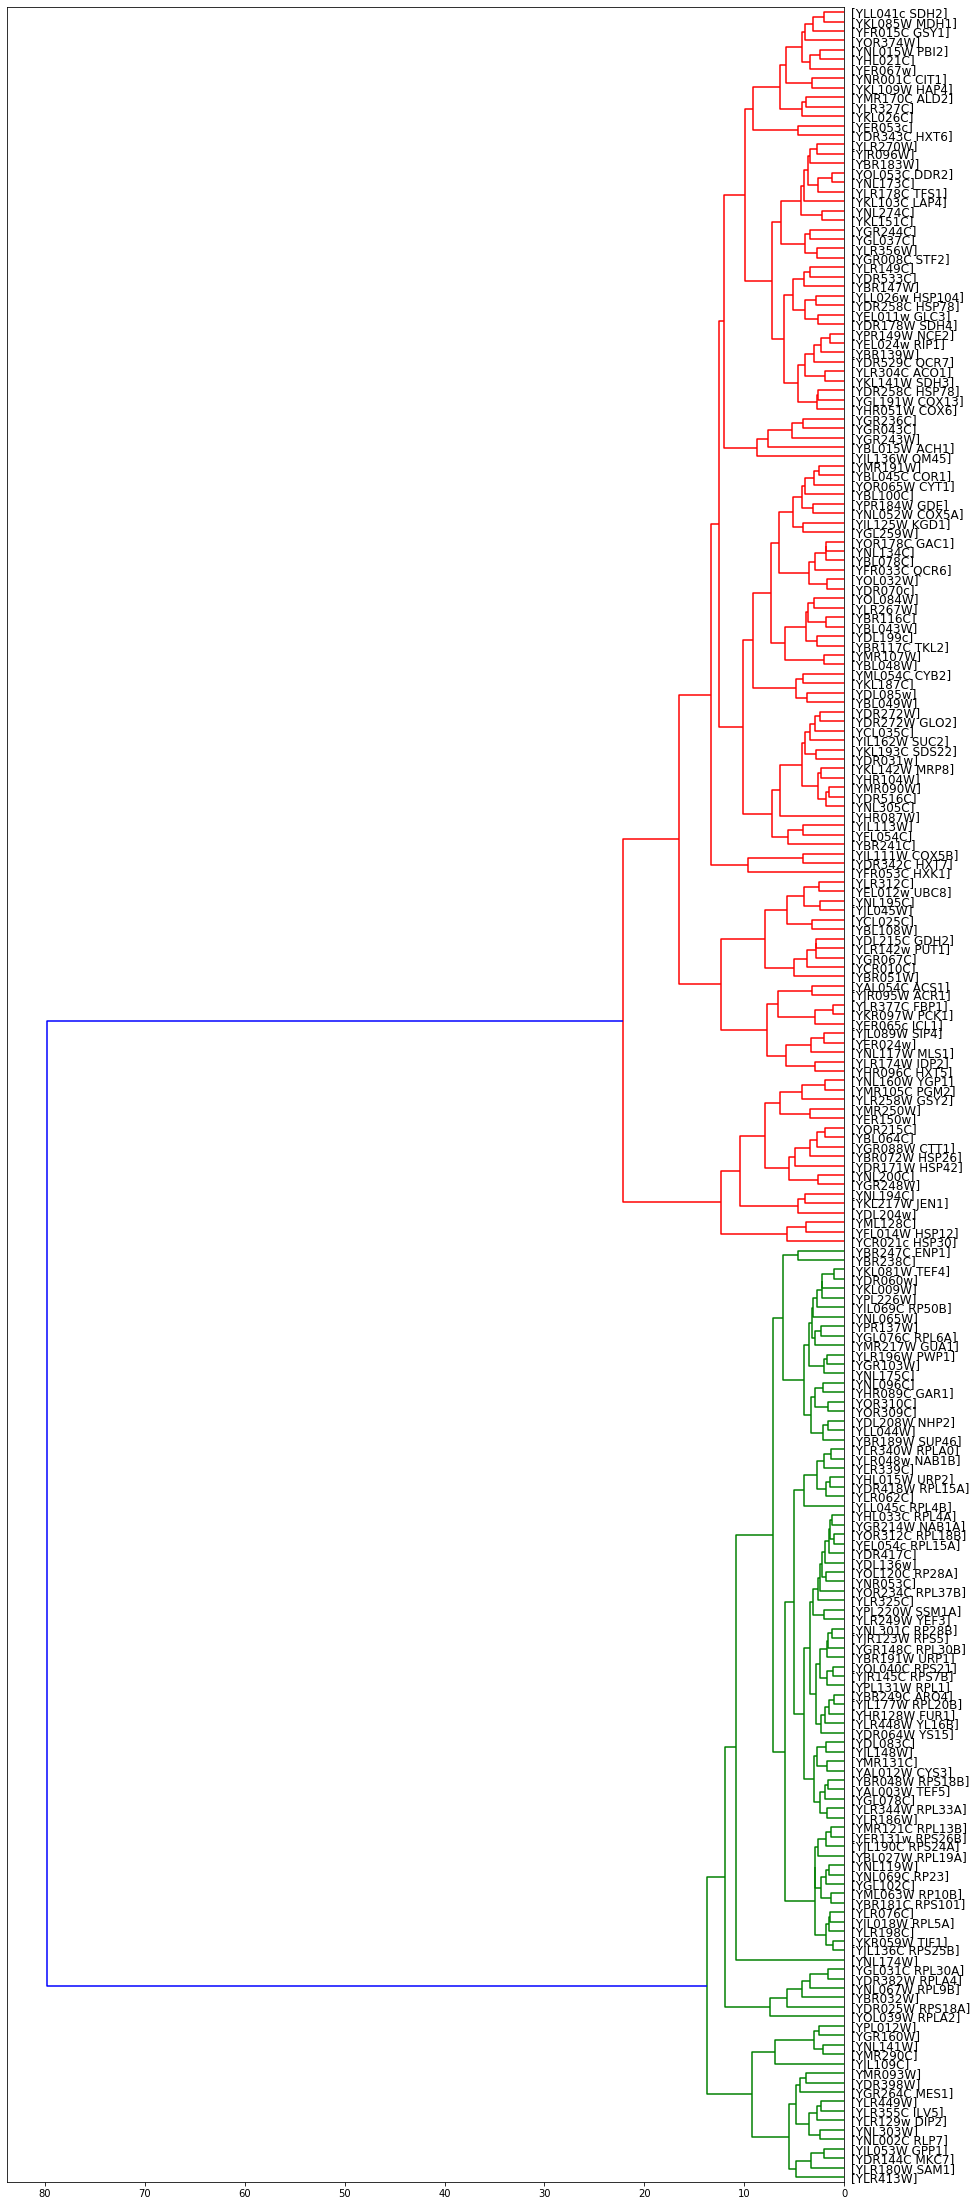

In [159]:
Get_Graph(dfm, 40)

# Evolutionary Tree

Import Data

In [160]:
df_ev_tree = pd.read_csv('D:/Data Science/Coursera/Bioinformatics/Data/mtDNA.csv')
df_ev_tree.head()

,species,mtDNA
0,W._Pygmy_(1)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...
1,W._Pygmy_(6)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...
2,Kung_(7)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...
3,Kung_(9)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...
4,Kung_(10)_{African},TTCTTTCATGGGGAAGCAGATTTGGGTACCACCCAAGTATTGACTC...


Getting different strings from mtDNAs

In [161]:
def Get_Different_String(X, Y):
    count = 0
    for x, y in zip(X, Y):
        if x != y:
            count += 1
    return(count)

Getting expression matrix

In [162]:
def Get_Species_Expression_Matrix(df):
    row = df.iloc[:, 1]
    l = len(row)
    mt = np.zeros((l, l))
    name = df.iloc[:, 0]
    pair_name = []
    
    for i in range(len(row)): 
        for j in range(len(row)):
            
            mt[i, j] = Get_Different_String(row[i], row[j])
                
    expression_matrix = pd.DataFrame(mt, name)
    old_col = expression_matrix.columns.values
    expression_matrix.rename(columns = dict(zip(old_col, name)), inplace = True)
        
    return(expression_matrix)
                

In [163]:
species_expression_matrix = Get_Species_Expression_Matrix(df_ev_tree)
species_expression_matrix

,W._Pygmy_(1)_{African},W._Pygmy_(6)_{African},Kung_(7)_{African},Kung_(9)_{African},Kung_(10)_{African},Kung_(13)_{African},Kung_(17)_{African},Kung_(19)_{African},Kung_(22)_{African},Asian_(23)_{Asian},...,European_(114)_{European},European_(115)_{European},European_(116)_{European},European_(117)_{European},European_(118)_{European},European_(119)_{European},European_(120)_{European},Asian_(122)_{Asian},Asian_(126)_{Asian},Asian_(128)_{Asian}
species,,,,,,,,,,,,,,,,,,,,,
W._Pygmy_(1)_{African},0.0,9.0,15.0,13.0,15.0,15.0,16.0,12.0,16.0,20.0,...,16.0,18.0,17.0,18.0,16.0,19.0,20.0,20.0,22.0,21.0
W._Pygmy_(6)_{African},9.0,0.0,15.0,15.0,15.0,17.0,20.0,14.0,18.0,18.0,...,14.0,16.0,13.0,14.0,14.0,15.0,18.0,16.0,18.0,17.0
Kung_(7)_{African},15.0,15.0,0.0,2.0,2.0,4.0,9.0,3.0,13.0,17.0,...,13.0,15.0,12.0,13.0,11.0,10.0,13.0,13.0,15.0,12.0
Kung_(9)_{African},13.0,15.0,2.0,0.0,4.0,6.0,11.0,5.0,11.0,17.0,...,13.0,15.0,12.0,13.0,11.0,10.0,13.0,13.0,15.0,12.0
Kung_(10)_{African},15.0,15.0,2.0,4.0,0.0,2.0,9.0,3.0,13.0,17.0,...,13.0,15.0,12.0,13.0,11.0,10.0,13.0,13.0,15.0,12.0
Kung_(13)_{African},15.0,17.0,4.0,6.0,2.0,0.0,9.0,3.0,11.0,17.0,...,13.0,17.0,14.0,15.0,13.0,12.0,13.0,15.0,17.0,14.0
Kung_(17)_{African},16.0,20.0,9.0,11.0,9.0,9.0,0.0,6.0,16.0,20.0,...,14.0,16.0,15.0,16.0,14.0,15.0,16.0,15.0,18.0,15.0
Kung_(19)_{African},12.0,14.0,3.0,5.0,3.0,3.0,6.0,0.0,10.0,14.0,...,10.0,14.0,11.0,12.0,10.0,11.0,12.0,12.0,14.0,11.0
Kung_(22)_{African},16.0,18.0,13.0,11.0,13.0,11.0,16.0,10.0,0.0,18.0,...,16.0,20.0,17.0,18.0,16.0,17.0,18.0,18.0,19.0,17.0


In [56]:
#Get_Hierarchical_Clustering(species_expression_matrix, 'average')

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


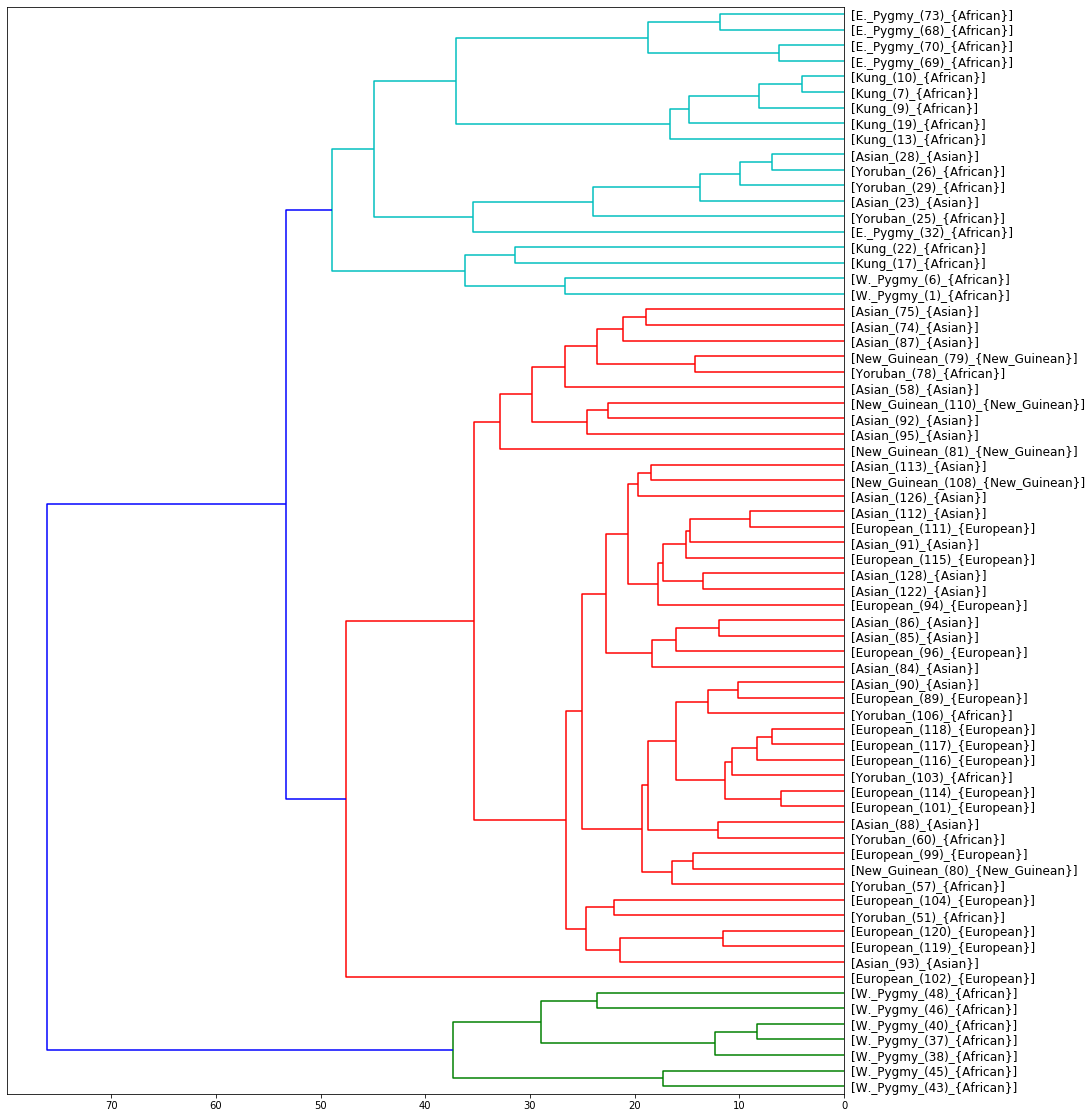

In [164]:
Get_Graph(species_expression_matrix, 20)